# MATH 60210 

Nasim Siami

<AxesSubplot:title={'center':'S&P Composite Index'}, xlabel='Date'>

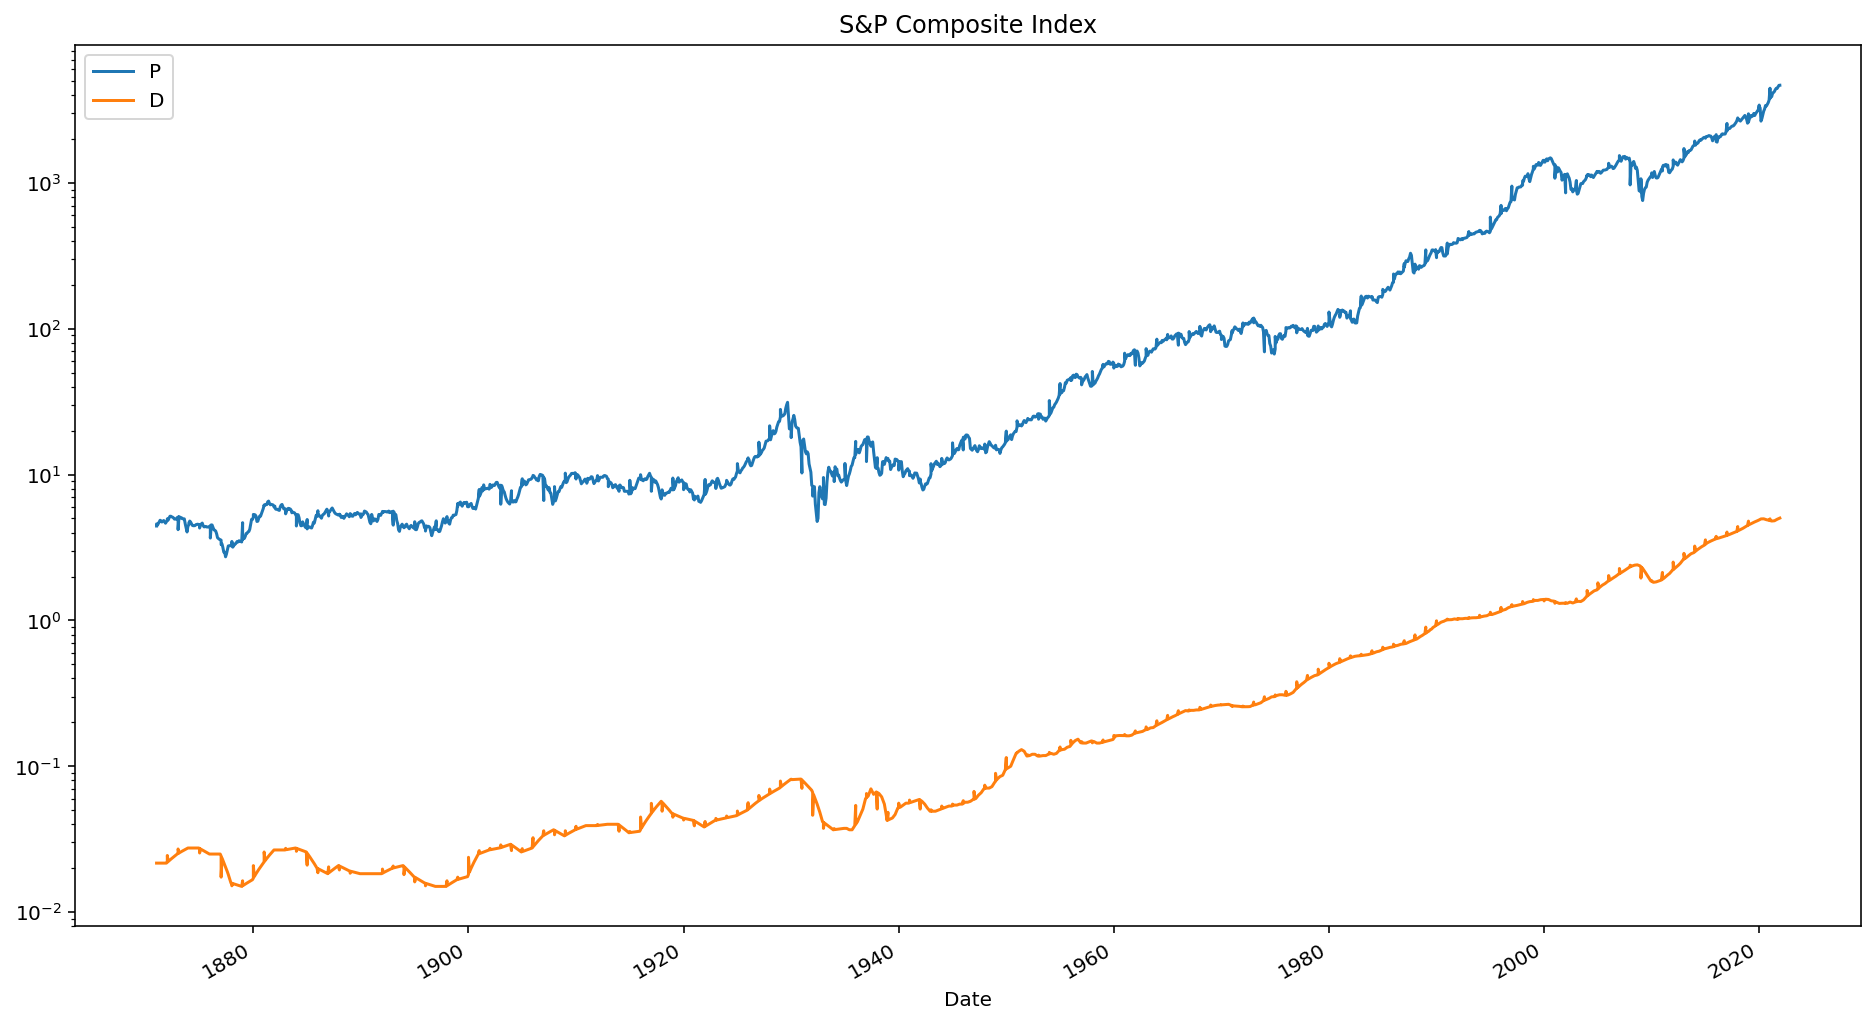

In [1]:
import numpy as np
import numpy.random as npr
import pandas as pd
import scipy.stats as ss
import statsmodels.api as sm

import warnings

warnings.filterwarnings("ignore",
                        message="A date index has been provided, but")
warnings.filterwarnings("ignore", message="No supported index is available.")
warnings.filterwarnings(
    "ignore",
    message="Only PeriodIndexes, DatetimeIndexes with a frequency set,")

PDdata = pd.read_excel('ie_data.xlsx',
                       'Data',
                       header=7,
                       index_col=0,
                       usecols='A:C',
                       parse_dates=True,
                       skipfooter=3)
# We need to convert from annual to monthly dividends
PDdata['D'] = PDdata['D'].div(12)

PDdata.plot(logy=True, title='S&P Composite Index', figsize=[16, 9])

## Question 1

### Part a

Write a function that accepts a DataFrame containing $[P,D]$ and returns a DataFrame containing $[p-d,\Delta d, r]$.<br>
**Be sure to drop any rows containing NAs.**

- See the slides for Lecture 4 -- just before equation (16) -- for the definitions of $p, d$ and $r$.

In [2]:
def PDtransform(df):
    """
    Accepts a DataFrame containing Prices ('P') and Dividends ('D') in columns 0 and 1
    Returns a DataFrame containing [p-d, Delta d, r] 
        for use in the Campbell-Shiller decomposition
    """
    ### BEGIN SOLUTION
    newdata = sm.tsa.lagmat2ds(df,maxlag0=1,use_pandas=True)
    newdata['pd'] = np.log(newdata['P'] / newdata['D'])
    newdata['Dd'] = np.log(newdata['D'] / newdata['D.L.1'])
    newdata['r']  = np.log( (newdata['P'] + newdata['D']) / newdata['P.L.1'] )
    return newdata[['pd','Dd','r']].tail(-1)
    ### END SOLUTION

In [3]:
Q1a = PDtransform(PDdata)

assert Q1a.shape == (1811,3)
assert Q1a.isna().any().any() == False
assert np.allclose(Q1a.iloc[0], (5.336058, 0, 0.018226), atol=1e-6)
assert np.allclose(Q1a.iloc[1810], (6.833901, 0.006326, 0.002657), atol=1e-6)

### Part b

Write a function that accepts the output of `PDtransform()` and returns a dict giving the optimal lag length for a VAR based on the AIC, BIC and HQIC criteria.

- the dict should have 'AIC', 'BIC' and 'HQIC' as its keys.
- its values should be integers.



In [4]:
from statsmodels.tsa.api import VAR

def pickVARlags(df,maxlags):  
    """
    This function determines the optimal lag length for a VAR.
    It accepts a DataFrame (df) containing the series for the VAR 
        and a maximum number of lags to test (maxlags).
    It returns a dict containing the optimal lag lengths according to the AIC, BIC and HQIC criteria.
    """
    ### BEGIN SOLUTION
    # Let's define the model
    Vmodel = VAR(df)
    # Let's find the optimal lag lengths
    BICfit  = Vmodel.fit(maxlags=maxlags, ic = 'bic')
    AICfit  = Vmodel.fit(maxlags=maxlags, ic = 'aic')
    HQICfit = Vmodel.fit(maxlags=maxlags, ic = 'hqic')
    # return the results
    return {'AIC': AICfit.k_ar, 
            'BIC': BICfit.k_ar, 
            'HQIC': HQICfit.k_ar}
    
    ### END SOLUTION

In [5]:
# Suppose we set maxlags = 3
IClags = pickVARlags(Q1a,maxlags=3)
assert IClags['AIC'] == 3
assert IClags['BIC'] == 3
assert IClags['HQIC'] == 3

# Suppose we set maxlags = 6
IClags = pickVARlags(Q1a,maxlags=6)
assert IClags['AIC'] == 6
assert IClags['BIC'] == 4
assert IClags['HQIC'] == 5

# Suppose we set maxlags = 24
IClags = pickVARlags(Q1a,maxlags=24)
assert IClags['AIC'] == 15
assert IClags['BIC'] == 4
assert IClags['HQIC'] == 5

### Part c

Write a function that accepts a DataFrame in the format produced by part (a) above and returns the values of $k$ and $\rho$ used in the present-value relationship given in equation (22) in Lecture 4. 

- formulas are given in the footnote at the bottom of the same slide. 



In [6]:
def k_and_rho(df):
    """
    This function calculates the constants used in the present-value relationship
    of the Campbell-Shiller Decomposition.
    - It accepts a DataFrame in the format produced by PDtransform()
    - It returns k and rho.
    """
    ### BEGIN SOLUTION
    pd_bar = df['pd'].mean(axis=0)
    rho = 1/(1 + np.exp(-pd_bar))
    k = - np.log(rho) - (1 - rho)*np.log(1/rho -1)
    ### END SOLUTION
    return k, rho

In [7]:
StPatrick = 20220317
np.random.seed(StPatrick)

df_test = pd.DataFrame(np.random.rand(1200,3)+8,columns=[['pd','Dd','r']])
k, rho = k_and_rho(df_test)
assert np.isclose(k, 0.001925, atol=1e-6)
assert np.isclose(rho, 0.999798, atol=1e-6)

df_test = df_test - 1
k, rho = k_and_rho(df_test)
assert np.isclose(k, 0.00468, atol=1e-6)
assert np.isclose(rho, 0.99945, atol=1e-6)

### Part d

Write a function that takes as arguments

- a `VARResults` object
- an integer `horizon`

and returns an array containing forecasts from the VAR model for the next `horizon` periods.

*Hint:* you may find the `.endog` attribute of `VARResults` useful for this, as well as the `.forecast()` method.



In [8]:
def VARforecast(varoutput, h):
    """
    This computes forecasts for the next h periods from a VAR model
    """
    ### BEGIN SOLUTION
    numlags = varoutput.k_ar
    startobs = varoutput.endog[-numlags:]
    return varoutput.forecast(startobs, h)
    ### END SOLUTION

In [9]:
Vmodel = VAR(Q1a)
Q1fit = Vmodel.fit(12)
BigF = VARforecast(Q1fit, 100)
BiggerF = VARforecast(Q1fit, 600)

BigF[99]

assert BigF.shape == (100, 3)
assert BiggerF.shape == (600, 3)
assert np.allclose(BigF[99], (6.80723617e+00, 5.46258670e-03, 4.93194254e-03))
assert np.allclose(BiggerF[317],
                   (6.59964448e+00, 4.96657427e-03, 5.34775480e-03))

### Part e

Using your results above, write a function that 

- accepts a DataFrame containing monthly data on stock market prices (P) and dividends (D)
- transforms them into $p-d,\Delta d$ and  $r$
- uses the $p-d$ series to estimate $k$ and $\rho$
- estimates a VAR model using the three transformed series, selecting the number of lags  (up to a maximum of 24) using the AIC
- constructs forecasts from the VAR model for the next 80 years
- approximates the sum on the right side of equation (22) in Lecture 4 using those 80 years of forecasts and estimated values of $k$ and $\rho$.
- returns the predicted value of $p-d$ at the end of 2021



In [10]:
def pd_CampbellShiller(df):
    """
    This function estimates the right-hand side of equation 22 in Lecture 4.
    """
    ### BEGIN SOLUTION
    logdata = PDtransform(df)  # transform the series
    VARmod22 = VAR(logdata)  # define the VAR model
    AIClags = pickVARlags(logdata, 24)['AIC']  # choose the lag length
    VARfit = VARmod22.fit(AIClags)  # estimate the VAR
    My_forecasts = VARforecast(
        VARfit, 960)  # construct the forecasts for 80 years = 960 months
    k, rho = k_and_rho(logdata)  # estimate k and rho
    VA_factor = rho**np.arange(1, 961)  # construct a vector with powers of rho
    VA = np.sum((My_forecasts[:, 1] - My_forecasts[:, 2]) *
                VA_factor)  # form the big summation
    return k / (1 - rho) + VA  # don't forget to add the constant!

    ### END SOLUTION

In [11]:
assert np.isclose(pd_CampbellShiller(PDdata), 6.605437361097138, rtol=2e-2)

---

## Question 2

For this question, we'll compare different forecasting models for the $p-d$ series that you created above.


### Part a

Write a function that accepts 

- a series `y`
- integers `p` and `hmax`

It fits an $AR(p)$ model to `y` and uses it to create forecasts of `y` for the next `hmax` periods. 



In [12]:
from statsmodels.tsa.ar_model import AutoReg


def ARfcst(y, p, hmax):  # modify function name and parameters
    """
    Estimates an AR(p) model and returns forecasts for the next hmax periods.
    """
    ### BEGIN SOLUTION
    ARres = AutoReg(y, p).fit()
    return ARres.forecast(steps=hmax)
    ### END SOLUTION

In [13]:
assert np.allclose(ARfcst(PDdata['P'], 4, 3),
                   [4705.867507, 4745.465987, 4793.457776])
assert np.allclose(ARfcst(PDdata['D'], 2, 3), [5.064463, 5.095492, 5.126208])

### Part b

Write a function that accepts

- a series `y`
- 3 integers: `T0`, `p`, `hmax`

It then 

1. applies `ARfcst()` to the first `T0` observations on `y` and stores the forecasts.
1. drops the first observation, adds the observation at `T0+1`, and repeats the previous step.
1. continues dropping the first observation, adding a new observation at the end, re-estimating the forecasting model and storing the new forecasts.

Once the last observation in y is used to estimate a model and the forecasts are made, the function returns an array of forecasts with `hmax` columns.



In [14]:
def rollAR(y, T0, p, hmax):
    """
    Computes AR forecasts using a rolling estimation window of size T0
    """
    ### BEGIN SOLUTION
    Nobs = y.shape[0]
    ARforecasts = np.empty([Nobs - T0, hmax])  # storage for forecasts
    for j in range(Nobs - T0):
        ARforecasts[j] = ARfcst(y[j:T0 + j], p, hmax)
    return ARforecasts
    ### END SOLUTION

In [15]:
assert np.allclose(
    rollAR(PDdata['D'], 1000, 2, 3)[0], [0.12145487, 0.12102348, 0.12064252])
assert np.allclose(
    rollAR(PDdata['P'], 1500, 3, 3)[-1],
    [4736.16350077, 4773.85411348, 4818.76841677])

### Part c

Write a function that accepts

- a 1-D array `d`
- an integer `h` indicating the forecast horizon

and returns Harvey, Leybourne and Newbold's Modified Diebold-Mariano statistic (`MDM`) <br>as well as its small-sample 2-tailed p-value (`pval`). 



In [16]:
def HLN_MDM(d, h):  # modify function name and parameters
    """
    Compute the Harvey, Leybourne and Newbold (1997) Modified-Diebold-Mariano statistic and its p-value
    """
    ### BEGIN SOLUTION
    tau = d.shape[0]
    MDMfix = np.sqrt((tau + 1 - 2 * h + h * (h - 1) / tau) / tau)
    d_bar = np.mean(d)
    sigma_d = np.sum(d * d)
    if h > 1:
        for j in range(h - 1):
            sigma_d += 2 * np.sum(d[1 + j:] * d[:tau - j - 1])
    sigma_d = np.sqrt(sigma_d / tau)
    MDM = MDMfix * d_bar / sigma_d
    pval = 2 * ss.t.cdf(-abs(MDM), tau - 1)
    ### END SOLUTION
    return MDM, pval

In [17]:
StPatrick = 20220317
np.random.seed(StPatrick)

mdm, pval = HLN_MDM(np.random.rand(200), 1)
assert np.isclose(mdm, 0.8638091757741851)
assert np.isclose(pval, 0.38873267740628525)

mdm, pval = HLN_MDM(np.random.rand(1000), 3)
assert np.isclose(mdm, 0.43265342045748767)
assert np.isclose(pval, 0.6653599560136534)

### Part d

Use your functions above to test the $H_0$ that forecasts from AR\(3\) model perform as well as an AR\(6\) in terms of MSE for forecasting 'p\-d'. 

- Construct the forecasts using rolling estimation of the AR model and an estimation window with a constant size of 300 observations. 
- Compare all forecast horizons from 1 to 24 mon  
  ths.

At which forecast horizons can you conclude (with 99% confidence) that the two models do not perform equally well?

(*Note:* For this exercise, you may ignore the size distortion problem with nested models.)



In [18]:
F_AR3 = rollAR(Q1a['pd'], 300, 3, 24)
F_AR6 = rollAR(Q1a['pd'], 300, 6, 24)

# Construct the forecast errors
###     Careful!     ###
# Along each row, each column is a forecast for a different period!
# ...and we don't have outcomes for all the forecasts in the last 24 rows
# Let's fix both of those problems!
for j in range(1, 24):
    F_AR3[:, j] = np.roll(F_AR3[:, j], j, axis=0)  # shift column j down by j-1
    F_AR6[:, j] = np.roll(F_AR6[:, j], j, axis=0)  # shift column j down by j-1
    # Don't forget to replace the rolled-over entries with NA!
    F_AR3[0:j, j] = np.nan
    F_AR6[0:j, j] = np.nan

# Now we can replace the forecasts with the forecast errors and run the MDM test
for j in range(24):
    # Construct the forecast errors for h = j+1
    F_AR3[:, j] = Q1a.iloc[300:, 0].values - F_AR3[:, j]
    F_AR6[:, j] = Q1a.iloc[300:, 0].values - F_AR6[:, j]
    # test MSE loss at h = j+1 (so d = difference in FE**2)
    d = F_AR3[:, j]**2 - F_AR6[:, j]**2
    # Note: Positive values imply AR(6) forecasts better than AR(3)
    # don't forget to drop the missing values!
    MDMstat, MDMpval = HLN_MDM(d[np.isfinite(d)], j + 1)
    print(
        f'For h = {j+1} and {len(d[np.isfinite(d)])} forecasts, the MDM stat. = {MDMstat:.3f} with a p-value = {MDMpval:.3f}.'
    )
print(
    '\nPositive values of the MDM statistic imply that the AR(6) forecasts better than the AR(3).'
)

For h = 1 and 1511 forecasts, the MDM stat. = -0.035 with a p-value = 0.972.
For h = 2 and 1510 forecasts, the MDM stat. = -0.032 with a p-value = 0.975.
For h = 3 and 1509 forecasts, the MDM stat. = -0.009 with a p-value = 0.993.
For h = 4 and 1508 forecasts, the MDM stat. = 0.005 with a p-value = 0.996.
For h = 5 and 1507 forecasts, the MDM stat. = 0.010 with a p-value = 0.992.
For h = 6 and 1506 forecasts, the MDM stat. = 0.007 with a p-value = 0.995.
For h = 7 and 1505 forecasts, the MDM stat. = -0.003 with a p-value = 0.998.
For h = 8 and 1504 forecasts, the MDM stat. = -0.016 with a p-value = 0.987.
For h = 9 and 1503 forecasts, the MDM stat. = -0.027 with a p-value = 0.979.
For h = 10 and 1502 forecasts, the MDM stat. = -0.035 with a p-value = 0.972.
For h = 11 and 1501 forecasts, the MDM stat. = -0.040 with a p-value = 0.968.
For h = 12 and 1500 forecasts, the MDM stat. = -0.043 with a p-value = 0.966.
For h = 13 and 1499 forecasts, the MDM stat. = -0.045 with a p-value = 0.964

(Your written answer goes here.)

We are *never* able to conclude that the two models do not perform equally well.<br>We always conclude that their performance is about equal.

### Part e

Use your functions above to test the $H_0$ that the AR(3) forecast-encompasses the AR(6) model.

Estimate the models as you did for part (d) above and for the same forecast horizons.

At which forecast horizons can you conclude (with 99% confidence) that the AR(6) model is not forecast-encompassed by the AR(3) model?

In [19]:
# To test whether the AR(3) forecast-encompasses the AR(6), we need to test whether
# the *difference* between the two forecasts is correlated with the forecast errors
# of the *AR(3)*.

for j in range(24):
    d = (F_AR3[:, j] - F_AR6[:, j]) * F_AR3[:, j]
    # Note: Positive values imply AR(6) forecasts better than AR(3)
    # don't forget to drop the missing values!
    MDMstat, MDMpval = HLN_MDM(d[np.isfinite(d)], j + 1)
    print(
        f'For h = {j+1} and {len(d[np.isfinite(d)])} forecasts, the MDM stat. = {MDMstat:.3f} with a p-value = {MDMpval:.3f}.'
    )
print(
    '\nRejections imply that the AR(3) does not forecast encompass the AR(6).')

For h = 1 and 1511 forecasts, the MDM stat. = -0.000 with a p-value = 1.000.
For h = 2 and 1510 forecasts, the MDM stat. = 0.029 with a p-value = 0.977.
For h = 3 and 1509 forecasts, the MDM stat. = 0.057 with a p-value = 0.954.
For h = 4 and 1508 forecasts, the MDM stat. = 0.060 with a p-value = 0.952.
For h = 5 and 1507 forecasts, the MDM stat. = 0.056 with a p-value = 0.955.
For h = 6 and 1506 forecasts, the MDM stat. = 0.052 with a p-value = 0.959.
For h = 7 and 1505 forecasts, the MDM stat. = 0.042 with a p-value = 0.966.
For h = 8 and 1504 forecasts, the MDM stat. = 0.028 with a p-value = 0.977.
For h = 9 and 1503 forecasts, the MDM stat. = 0.016 with a p-value = 0.987.
For h = 10 and 1502 forecasts, the MDM stat. = 0.005 with a p-value = 0.996.
For h = 11 and 1501 forecasts, the MDM stat. = -0.003 with a p-value = 0.998.
For h = 12 and 1500 forecasts, the MDM stat. = -0.009 with a p-value = 0.993.
For h = 13 and 1499 forecasts, the MDM stat. = -0.013 with a p-value = 0.990.
For 

(Your written answer goes here.)

There is no evidence to suggest that the AR\(3\) does not forecast\-encompass the AR\(6\).

